In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import nltk, spacy
import random, re 


from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from collections import Counter
from sklearn.svm  import LinearSVC

In [2]:
#Load dataset

imdb=load_dataset("imdb")
print(imdb.keys())

#bacis preprocessing
nltk.download('stopwords')
stopwords_en = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])

def lemmatize_text(text:str) -> str:
    
    doc = nlp(text.lower())
    lemmas = [
        tok.lemma_ for tok in doc
        if (tok.is_alpha or tok.is_digit)        
        and not tok.is_stop  
        and tok.text not in stopwords_en  
                                         
               
    ]
    return " ".join(lemmas)


dict_keys(['train', 'test', 'unsupervised'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#create NEUTRAL class
NEUTRAL_SIZE = 1_000
neutral_samples = random.sample(
    list(imdb["unsupervised"]["text"]), NEUTRAL_SIZE
)
neutral_labels = [2]*NEUTRAL_SIZE   # 2 = neutral

POS_NEG_SIZE = 1_000
pos_idx = [i for i,l in enumerate(imdb["train"]["label"]) if l==1][:POS_NEG_SIZE]
neg_idx = [i for i,l in enumerate(imdb["train"]["label"]) if l==0][:POS_NEG_SIZE]

texts  = (
    [imdb["train"]["text"][i] for i in pos_idx] +   # positive
    [imdb["train"]["text"][i] for i in neg_idx] +   # negative
    neutral_samples                                 # neutral
)
labels = [1]*POS_NEG_SIZE + [0]*POS_NEG_SIZE + neutral_labels

In [6]:

texts_lemma = [
    lemmatize_text(t) for t in texts         
]

Number of samples per category:
label
1    1000
0    1000
2    1000
Name: count, dtype: int64


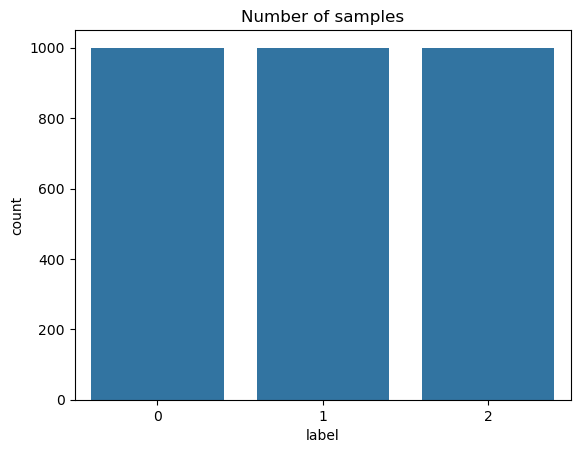

In [7]:
df = pd.DataFrame({"text": texts_lemma, "label": labels})

print("Number of samples per category:")
print(df["label"].value_counts())

sns.countplot(x="label", data=df)
plt.title("Number of samples")
plt.show()

The 20 most frequency words:
movie 6024
film 5605
like 2659
good 2432
time 1854
character 1779
watch 1630
story 1608
bad 1554
see 1499
think 1379
scene 1357
great 1203
look 1184
love 1144
go 1100
know 1090
get 1060
people 1050
way 1038


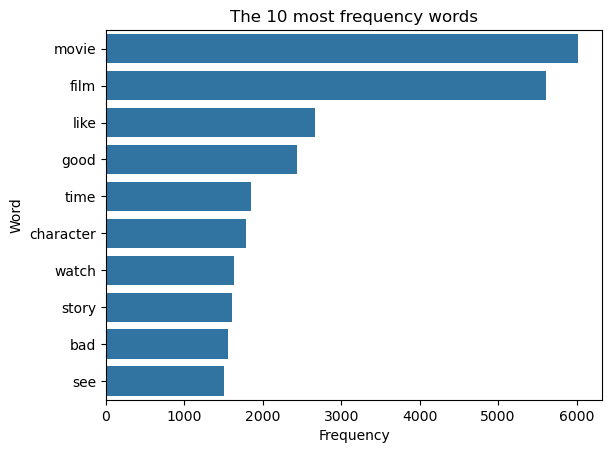

In [10]:
words = " ".join(df["text"]).split()
word_freq= Counter(words)

print("The 20 most frequency words:")
for word, freq in word_freq.most_common(20):
    print(word, freq)


top_words = pd.DataFrame(word_freq.most_common(10), columns=["Word", "Frequency"])
sns.barplot(data=top_words, x="Frequency", y="Word")
plt.title("The 10 most frequency words")
plt.show()

In [11]:
#train and test split 
X_train, X_test, y_train, y_test = train_test_split(
    texts_lemma, labels, test_size=0.30,
    random_state=42, stratify=labels
)

In [12]:
# -----------------------------------------------------
# TF-IDF  +  Logistic Regression
# -----------------------------------------------------
tfidf = TfidfVectorizer(
    ngram_range=(1,2), min_df=3, max_features=30_000
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

clf_tfidf = LogisticRegression(
    max_iter=400, multi_class='ovr',
    C=4, solver='liblinear'
).fit(X_train_tfidf, y_train)

y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

print("\n ====LR==== ")
print(classification_report(
    y_test, y_pred_tfidf,
    target_names=["Negative (0)", "Positive(1)", "Neutral (2)"]
))


 ====LR==== 
              precision    recall  f1-score   support

Negative (0)       0.62      0.66      0.64       300
 Positive(1)       0.74      0.76      0.75       300
 Neutral (2)       0.56      0.51      0.53       300

    accuracy                           0.64       900
   macro avg       0.64      0.64      0.64       900
weighted avg       0.64      0.64      0.64       900



c:\Users\dell\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [13]:
clf_svm = LinearSVC(C=1.0, max_iter=1000)
clf_svm.fit(X_train_tfidf, y_train)
y_pred_svm = clf_svm.predict(X_test_tfidf)

print("\n=== SVM ===")
print(classification_report(y_test, y_pred_svm, target_names=["Negative", "Positive", "Neutral"]))


=== SVM ===
              precision    recall  f1-score   support

    Negative       0.61      0.66      0.63       300
    Positive       0.75      0.75      0.75       300
     Neutral       0.56      0.52      0.54       300

    accuracy                           0.64       900
   macro avg       0.64      0.64      0.64       900
weighted avg       0.64      0.64      0.64       900



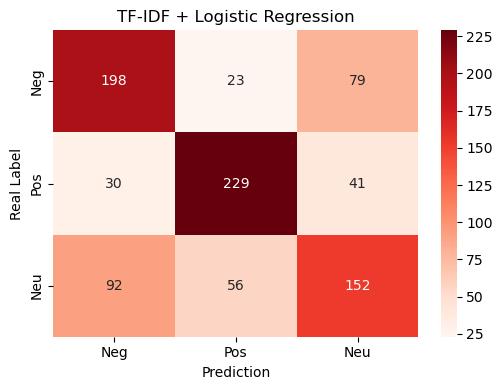

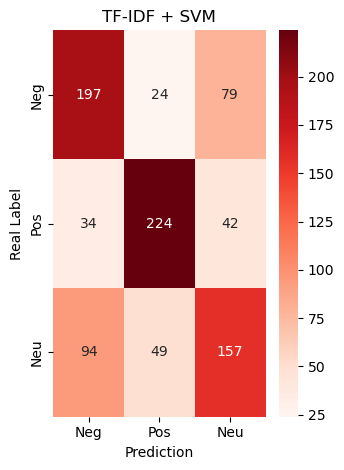

In [14]:
def plot_cm(cm, title):
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Reds",
        xticklabels=["Neg", "Pos", "Neu"],
        yticklabels=["Neg", "Pos", "Neu"]
    )
    plt.title(title)
    plt.ylabel("Real Label")
    plt.xlabel("Prediction")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_test, y_pred_tfidf),
        "TF-IDF + Logistic Regression")

plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_test, y_pred_svm),
        "TF-IDF + SVM")